## First check if you have GPU available in your PC.

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12428432913424102807
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6656998955338703099
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4928812339
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15603067733592656495
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11884010164694950953
physical_device_desc: "device: XLA_GPU device"
]


# CNN

In [2]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

##################################################
# Set current directory
##################################################

currentDirectory=os.getcwd()#current working directory

DATA_BASE_FOLDER = '../data'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# check tensorflow version
tf.__version__

'2.2.0'

In [5]:
# function to plot accuracy on TS and VS in same figure
def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['accuracy'], label = "Accuracy on TS")
    plt.plot(history.epoch,history.history['val_accuracy'], label = "Accuracy on VS")
    plt.legend()
    plt.title('accuracy')

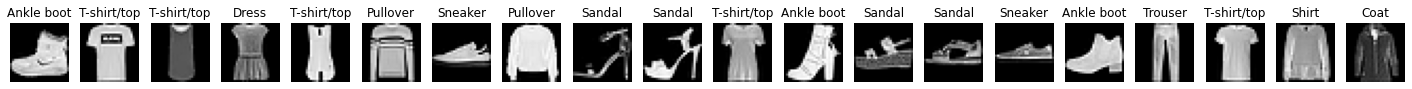

In [6]:
##################################################
# Load dataset
##################################################

x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [7]:
#SET SIZE = size of training set to use. Use 50000 to use full TS
size = 50000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:int(size/5)]/255
x_test_sc =x_test/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:int(size/5)]

x_train_sc=x_train_sc.reshape(size,28,28,1)
x_valid_sc=x_valid_sc.reshape(int(size/5),28,28,1)

print("Size of x_train_sc is now: {}".format(x_train_sc.shape))
print("Size of x_valid_sc is now: {}".format(x_valid_sc.shape))

print("Size of y_train_sc is now: {}".format(y_train_sc.shape))
print("Size of y_valid_sc is now: {}".format(y_valid_sc.shape))

Size of x_train_sc is now: (50000, 28, 28, 1)
Size of x_valid_sc is now: (10000, 28, 28, 1)
Size of y_train_sc is now: (50000,)
Size of y_valid_sc is now: (10000,)


# First NN

First Neural Network - 2 Convolutional layers (with pooling) and a single dense final layer

In [8]:
##### First Neural Network - 2 Convolutional layers (with pooling) and a single dense final layer ####
def model1(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters=32,
               kernel_size=(3, 3), 
               name='conv0', 
               padding='same',
               activation='relu')(X_input)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2), padding='same')(X)
    X=Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(X)
    X=MaxPooling2D((2, 2), padding='same')(X)
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model1')

    return model

In [9]:
input_shape=(28,28,1)  
model1 = model1(input_shape)

model1.compile(optimizer = "adam", 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                15690

In [10]:
history = model1.fit(x = x_train_sc, y = y_train_sc, epochs = 20, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Epoch 1/20
391/391 [==============================] - 2s 6ms/step - loss: 0.6178 - accuracy: 0.7833 - val_loss: 0.4296 - val_accuracy: 0.8517
Epoch 2/20
391/391 [==============================] - 2s 6ms/step - loss: 0.3849 - accuracy: 0.8639 - val_loss: 0.3738 - val_accuracy: 0.8676
Epoch 3/20
391/391 [==============================] - 2s 5ms/step - loss: 0.3429 - accuracy: 0.8782 - val_loss: 0.3494 - val_accuracy: 0.8780
Epoch 4/20
391/391 [==============================] - 2s 6ms/step - loss: 0.3119 - accuracy: 0.8912 - val_loss: 0.3201 - val_accuracy: 0.8875
Epoch 5/20
391/391 [==============================] - 2s 5ms/step - loss: 0.2937 - accuracy: 0.8974 - val_loss: 0.3005 - val_accuracy: 0.8927
Epoch 6/20
391/391 [==============================] - 2s 6ms/step - loss: 0.2767 - accuracy: 0.9027 - val_loss: 0.2929 - val_accuracy: 0.8957
Epoch 7/20
391/391 [==============================] - 2s 6ms/step - loss: 0.2648 - accuracy: 0.9063 - val_loss: 0.2721 - val_accuracy: 0.9026
Epoch 

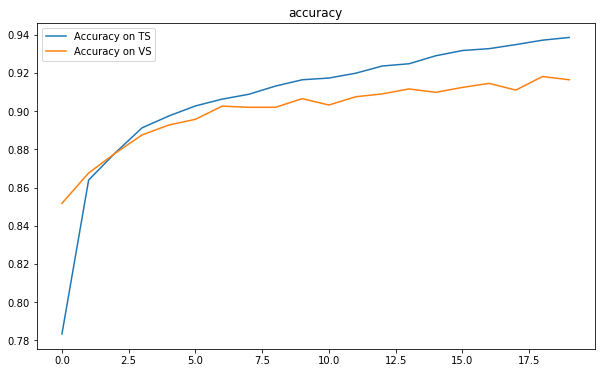

In [11]:
plot_accuracy(history)

# Second try

Second Neural Network - 1 Convolutional layers (with pooling) and a single dense final layer


In [14]:
##### Second Neural Network - 1 Convolutional layers (with pooling) and a single dense final layer ####
# ADAMAX OPTIMIZER

def model2(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters=64,
               kernel_size=(5, 5), 
               name='conv0', 
               padding='same',
               activation='relu')(X_input)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(X)
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model2')

    return model

input_shape=(28,28,1)  
model2 = model2(input_shape)

# keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.99, beta_2=0.999)
# "adam"

model2.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.99, beta_2=0.999), 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model2.summary()

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                501770    
Total params: 503,434
Trainable params: 503,434
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model2.fit(x = x_train_sc, y = y_train_sc, epochs = 10, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Epoch 1/10
391/391 [==============================] - 4s 10ms/step - loss: 0.5056 - accuracy: 0.8245 - val_loss: 0.3940 - val_accuracy: 0.8595
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3498 - accuracy: 0.8769 - val_loss: 0.3474 - val_accuracy: 0.8765
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3037 - accuracy: 0.8949 - val_loss: 0.3058 - val_accuracy: 0.8921
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2832 - accuracy: 0.9003 - val_loss: 0.2938 - val_accuracy: 0.8940
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2634 - accuracy: 0.9081 - val_loss: 0.2795 - val_accuracy: 0.9025
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2461 - accuracy: 0.9133 - val_loss: 0.2753 - val_accuracy: 0.9038
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2357 - accuracy: 0.9180 - val_loss: 0.2774 - val_accuracy: 0.8994

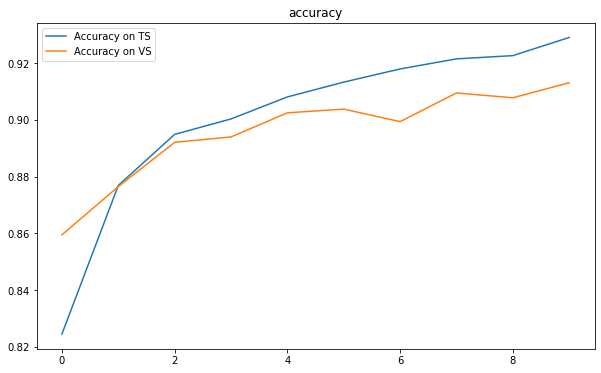

In [16]:
plot_accuracy(history)

In [17]:
model2.evaluate(x_valid_sc, y_valid_sc, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.2516 - accuracy: 0.9131


[0.25156763195991516, 0.913100004196167]

# Third Try

Second Neural Network - 2 Convolutional layers (with pooling), increasing kernels and a single dense final layer


In [18]:
##### Second Neural Network - 1 Convolutional layers (with pooling) and a single dense final layer ####
# ADAMAX OPTIMIZER

def model3(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters=32,
               kernel_size=(3, 3), 
               name='conv0', 
               padding='same',
               activation='relu')(X_input)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2), padding='same')(X)
    X = Conv2D(filters=64,
               kernel_size=(3, 3), 
               name='conv1', 
               padding='same',
               activation='relu')(X)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2), padding='same')(X)
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model3')

    return model

input_shape=(28,28,1)  
model3 = model3(input_shape)

# keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.99, beta_2=0.999)
# "adam"
# "sgd"

model3.compile(optimizer ="adam", 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model3.summary()

Model: "model3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                31370

In [19]:
history = model3.fit(x = x_train_sc, y = y_train_sc, epochs = 15, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Epoch 1/15
391/391 [==============================] - 3s 7ms/step - loss: 0.5568 - accuracy: 0.8017 - val_loss: 0.4187 - val_accuracy: 0.8518
Epoch 2/15
391/391 [==============================] - 3s 7ms/step - loss: 0.3565 - accuracy: 0.8754 - val_loss: 0.3400 - val_accuracy: 0.8778
Epoch 3/15
391/391 [==============================] - 3s 7ms/step - loss: 0.3168 - accuracy: 0.8885 - val_loss: 0.3193 - val_accuracy: 0.8872
Epoch 4/15
391/391 [==============================] - 3s 7ms/step - loss: 0.2895 - accuracy: 0.8980 - val_loss: 0.3156 - val_accuracy: 0.8860
Epoch 5/15
391/391 [==============================] - 3s 7ms/step - loss: 0.2693 - accuracy: 0.9031 - val_loss: 0.2911 - val_accuracy: 0.8972
Epoch 6/15
391/391 [==============================] - 3s 7ms/step - loss: 0.2531 - accuracy: 0.9105 - val_loss: 0.2680 - val_accuracy: 0.9050
Epoch 7/15
391/391 [==============================] - 3s 7ms/step - loss: 0.2410 - accuracy: 0.9141 - val_loss: 0.2621 - val_accuracy: 0.9052
Epoch 

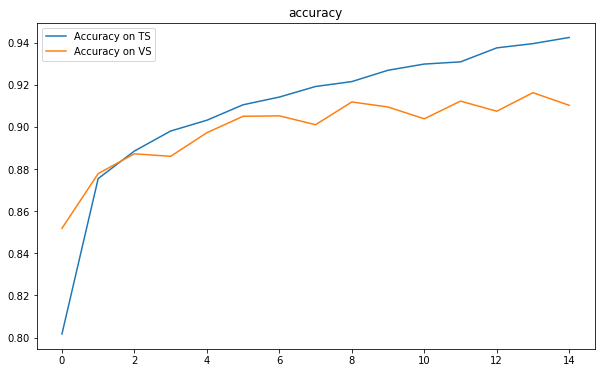

In [22]:
plot_accuracy(history)

In [23]:
model3.evaluate(x_valid_sc, y_valid_sc, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.2587 - accuracy: 0.9102


[0.2586589455604553, 0.9101999998092651]

# 4th Try

Second Neural Network - 2 Convolutional layers (with pooling), increasing kernels and a single dense final layer


In [68]:
##### Second Neural Network - 3 Convolutional layers (with pooling) and a single dense final layer ####
# ADAMAX OPTIMIZER

def model4(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters=32,
               kernel_size=(3, 3), 
               name='conv0', 
               padding='same',
               activation='relu')(X_input)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2), padding='same')(X)
    X = Conv2D(filters=64,
               kernel_size=(3, 3), 
               name='conv1', 
               padding='same',
               activation='relu')(X)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2), padding='same')(X)
    X = Conv2D(filters=128,
               kernel_size=(3, 3), 
               name='conv2', 
               padding='same',
               activation='relu')(X)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2), padding='same')(X)
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax', )(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model4')

    return model

input_shape=(28,28,1)  
model4 = model4(input_shape)

# keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.99, beta_2=0.999)
# "adam"
# "sgd"

model4.compile(optimizer ="adamax", 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model4.summary()

Model: "model4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 4, 4, 128)         0    

In [69]:
history = model4.fit(x = x_train_sc, y = y_train_sc, epochs = 15, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Epoch 1/15
196/196 [==============================] - 3s 16ms/step - loss: 0.7903 - accuracy: 0.7191 - val_loss: 0.5262 - val_accuracy: 0.8045
Epoch 2/15
196/196 [==============================] - 3s 14ms/step - loss: 0.4702 - accuracy: 0.8326 - val_loss: 0.4495 - val_accuracy: 0.8379
Epoch 3/15
196/196 [==============================] - 3s 14ms/step - loss: 0.4126 - accuracy: 0.8544 - val_loss: 0.4246 - val_accuracy: 0.8460
Epoch 4/15
196/196 [==============================] - 3s 14ms/step - loss: 0.3760 - accuracy: 0.8670 - val_loss: 0.3861 - val_accuracy: 0.8597
Epoch 5/15
196/196 [==============================] - 3s 14ms/step - loss: 0.3561 - accuracy: 0.8749 - val_loss: 0.3657 - val_accuracy: 0.8664
Epoch 6/15
196/196 [==============================] - 3s 14ms/step - loss: 0.3347 - accuracy: 0.8799 - val_loss: 0.3372 - val_accuracy: 0.8789
Epoch 7/15
196/196 [==============================] - 3s 14ms/step - loss: 0.3182 - accuracy: 0.8869 - val_loss: 0.3202 - val_accuracy: 0.8856

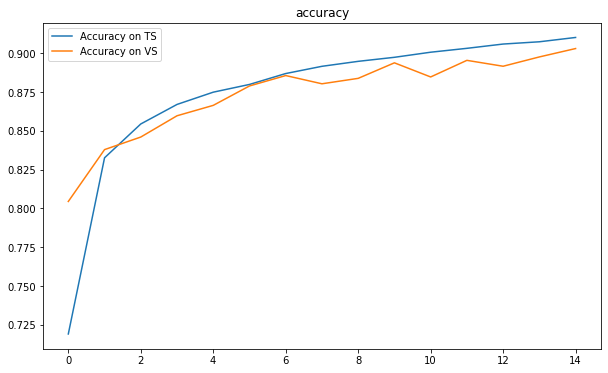

In [70]:
plot_accuracy(history)

In [71]:
model4.evaluate(x_valid_sc, y_valid_sc, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.2678 - accuracy: 0.9030


[0.2678449749946594, 0.902999997138977]

# 5th Try

Second Neural Network - 4 Convolutional layers, grouped 2 by 2 (with pooling), increasing kernels and a single dense final layer. After the max pooling layers we also add a dropout layer as a measure to prevent overfitting.


In [68]:
##### Second Neural Network - 3 Convolutional layers (with pooling) and a single dense final layer ####
# ADAMAX OPTIMIZER

def model5(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters=16,
               kernel_size=(3, 3), 
               name='conv00', 
               padding='same',
               activation='relu')(X_input)#'same' preserve the dimension of input through the convolutions
    X = Conv2D(filters=16,
               kernel_size=(3, 3), 
               name='conv01', 
               padding='same',
               activation='relu')(X)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(filters=32,
               kernel_size=(3, 3), 
               name='conv10', 
               padding='same',
               activation='relu')(X)#'same' preserve the dimension of input through the convolutions
    X = Conv2D(filters=32,
               kernel_size=(3, 3), 
               name='conv011', 
               padding='same',
               activation='relu')(X)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='model5')

    return model

input_shape=(28,28,1)  
model5 = model5(input_shape)

# keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.99, beta_2=0.999)
# "adam"
# "sgd"

model5.compile(optimizer ="adam", 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model5.summary()

Model: "model5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv00 (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv01 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv10 (Conv2D)              (None, 14, 14, 32)        4640      
_________________________________________________________________
conv011 (Conv2D)             (None, 14, 14, 32)        9248 

In [69]:
history = model5.fit(x = x_train_sc, y = y_train_sc, epochs = 25, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Epoch 1/25
391/391 [==============================] - 3s 8ms/step - loss: 0.6579 - accuracy: 0.7598 - val_loss: 0.4003 - val_accuracy: 0.8558
Epoch 2/25
391/391 [==============================] - 3s 8ms/step - loss: 0.3945 - accuracy: 0.8580 - val_loss: 0.3336 - val_accuracy: 0.8816
Epoch 3/25
391/391 [==============================] - 3s 8ms/step - loss: 0.3447 - accuracy: 0.8755 - val_loss: 0.2996 - val_accuracy: 0.8917
Epoch 4/25
391/391 [==============================] - 3s 8ms/step - loss: 0.3082 - accuracy: 0.8894 - val_loss: 0.2833 - val_accuracy: 0.8965
Epoch 5/25
391/391 [==============================] - 3s 8ms/step - loss: 0.2875 - accuracy: 0.8973 - val_loss: 0.2600 - val_accuracy: 0.9046
Epoch 6/25
391/391 [==============================] - 3s 8ms/step - loss: 0.2702 - accuracy: 0.9027 - val_loss: 0.2545 - val_accuracy: 0.9069
Epoch 7/25
391/391 [==============================] - 3s 8ms/step - loss: 0.2558 - accuracy: 0.9076 - val_loss: 0.2445 - val_accuracy: 0.9111
Epoch 

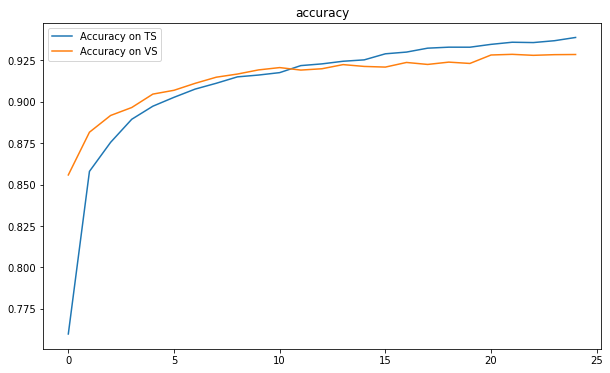

In [70]:
plot_accuracy(history)

In [71]:
model5.evaluate(x_valid_sc, y_valid_sc, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.1944 - accuracy: 0.9285


[0.1943548172712326, 0.9284999966621399]

In [72]:
x_test_reshaped = x_test_sc.reshape(x_test_sc.shape[0],28,28,1)
y_predictions_softmax = model5.predict(x_test_reshaped)

In [73]:
# our network predictions are in the format of a 10 component vector, which is the output of the softmax function.
# We need to take the argmax of those vectors!

y_predictions_cnn = np.argmax(y_predictions_softmax, axis = 1)
print(y_predictions_cnn.shape)

(10000,)


In [74]:
# save that on a .csv file for the submission
predictions_cnn_file = pd.DataFrame(y_predictions_cnn)
predictions_cnn_file = predictions_cnn_file.to_csv('y_predictions_cnn.csv', sep=',',index=False)

In [75]:
# save model to disk
model5.save('cnn5.h5')

In [43]:
# to load the model from disk run this
model_imported = tf.keras.models.load_model('cnn5.h5')

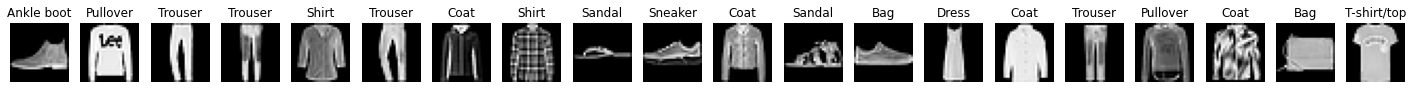

In [52]:
# Plot random images of test set with the prediction
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_test_sc[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_predictions_cnn[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

Seems that most are correct!